In [1]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [2]:
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import swifter

In [3]:
from plotting import format_plot, save_plot
from constants import JULIAN_DAY
from spice_tools import as_et, as_utc
from simulation_tools import load_simulation_results
from util import cart2track

In [4]:
def load_and_tf(folder):
    def tf(row):
        acc = row[["acc_rp_earth_x", "acc_rp_earth_y", "acc_rp_earth_z"]].to_numpy()
        pos = row[["pos_x", "pos_y", "pos_z"]].to_numpy()
        vel = row[["vel_x", "vel_y", "vel_z"]].to_numpy()

        row["acc_rp_earth_radial"], row["acc_rp_earth_along"], row["acc_rp_earth_cross"] = cart2track(acc, vel, pos)

        return row

    df = load_simulation_results(folder)
    return df.iloc[:, :].apply(tf, axis=1)

In [5]:
def plot_accelerations(dfs, labels, skip=[], scale_y=1):
    fig, axs = plt.subplots(4, 1, figsize=(12, 10*scale_y), sharex="all")
    ax_mag, ax_radial, ax_along, ax_cross = axs

    for df, label in zip(dfs, labels):
        if label in skip:
            continue
        ax_mag.plot(df.index, df["acc_rp_earth"], label=label)
        ax_radial.plot(df.index, df["acc_rp_earth_radial"])
        ax_along.plot(df.index, df["acc_rp_earth_along"])
        ax_cross.plot(df.index, df["acc_rp_earth_cross"])

    ax_mag.set_title("magnitude")
    ax_radial.set_title("radial")
    ax_along.set_title("along")
    ax_cross.set_title("cross")
    ax_mag.legend()

    for ax in axs.flat:
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

def plot_magnitude(dfs, labels, skip=[]):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex="all")

    for df, label in zip(dfs, labels):
        if label in skip:
            continue
        ax.plot(df.index, df["acc_rp_earth"], label=label)

    ax.set_title("magnitude")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

# Static vs dynamic paneling

## Constant distribution

In [6]:
# dynamic {12} with constant albedo
df_const_dynamic_single = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_single")

In [7]:
# dynamic {6, 12} with constant albedo
df_const_dynamic_double = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_double")

In [8]:
# dynamic {24, 36, 48} with constant albedo
df_const_dynamic_hires = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_hires")

In [9]:
# dynamic {36, 36, 48, 48} with constant albedo
df_const_dynamic_superres = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_superres")

In [10]:
# static 100 with constant albedo
df_const_static_100 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_static_100")

In [11]:
# static 200 with constant albedo
df_const_static_200 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_static_200")

In [12]:
# static 2000 with constant albedo
df_const_static_2000 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_static_2000")

In [13]:
# static 10000 with constant albedo
df_const_static_10000 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_static_10000")

In [14]:
# static 20000 with constant albedo
df_const_static_20000 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_static_20000")

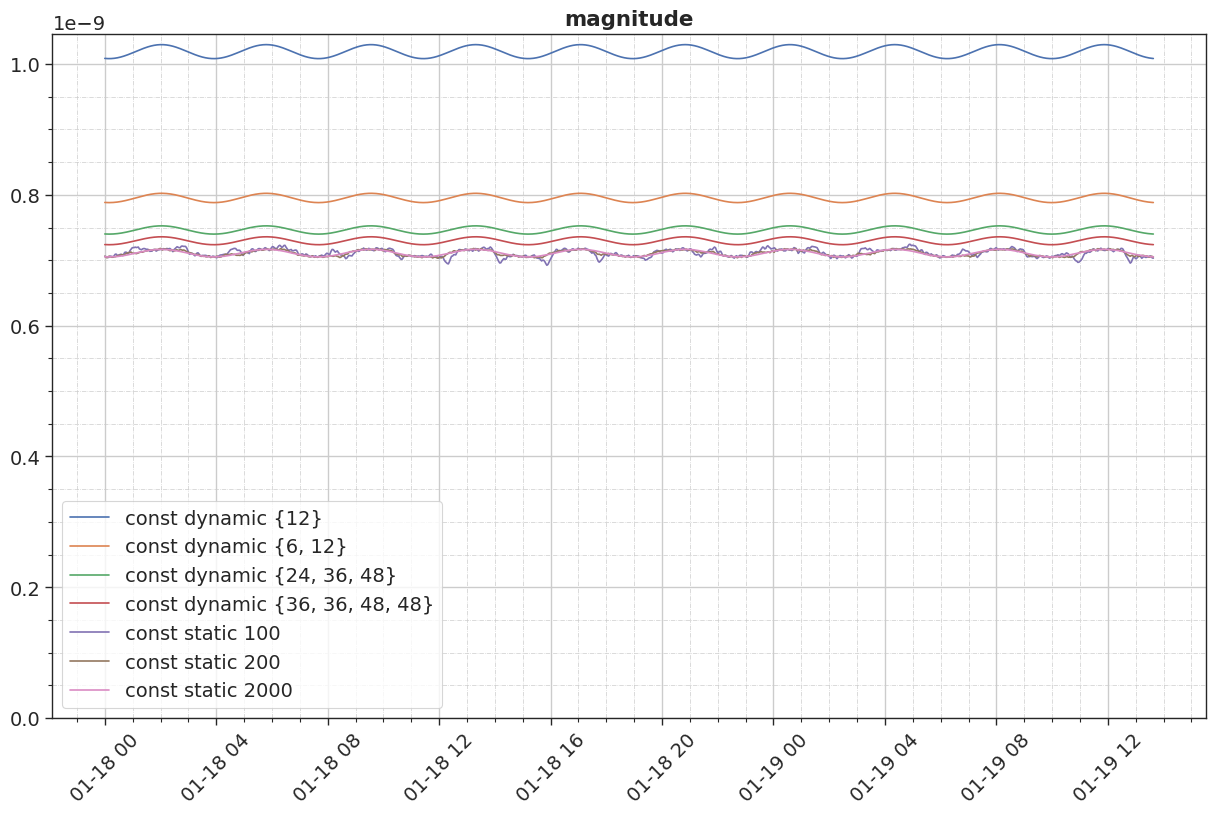

In [15]:
plot_magnitude(
    [df_const_dynamic_single, df_const_dynamic_double, df_const_dynamic_hires, df_const_dynamic_superres, df_const_static_100, df_const_static_200, df_const_static_2000],
    ["const dynamic {12}", "const dynamic {6, 12}", "const dynamic {24, 36, 48}", "const dynamic {36, 36, 48, 48}", "const static 100", "const static 200", "const static 2000"]
)

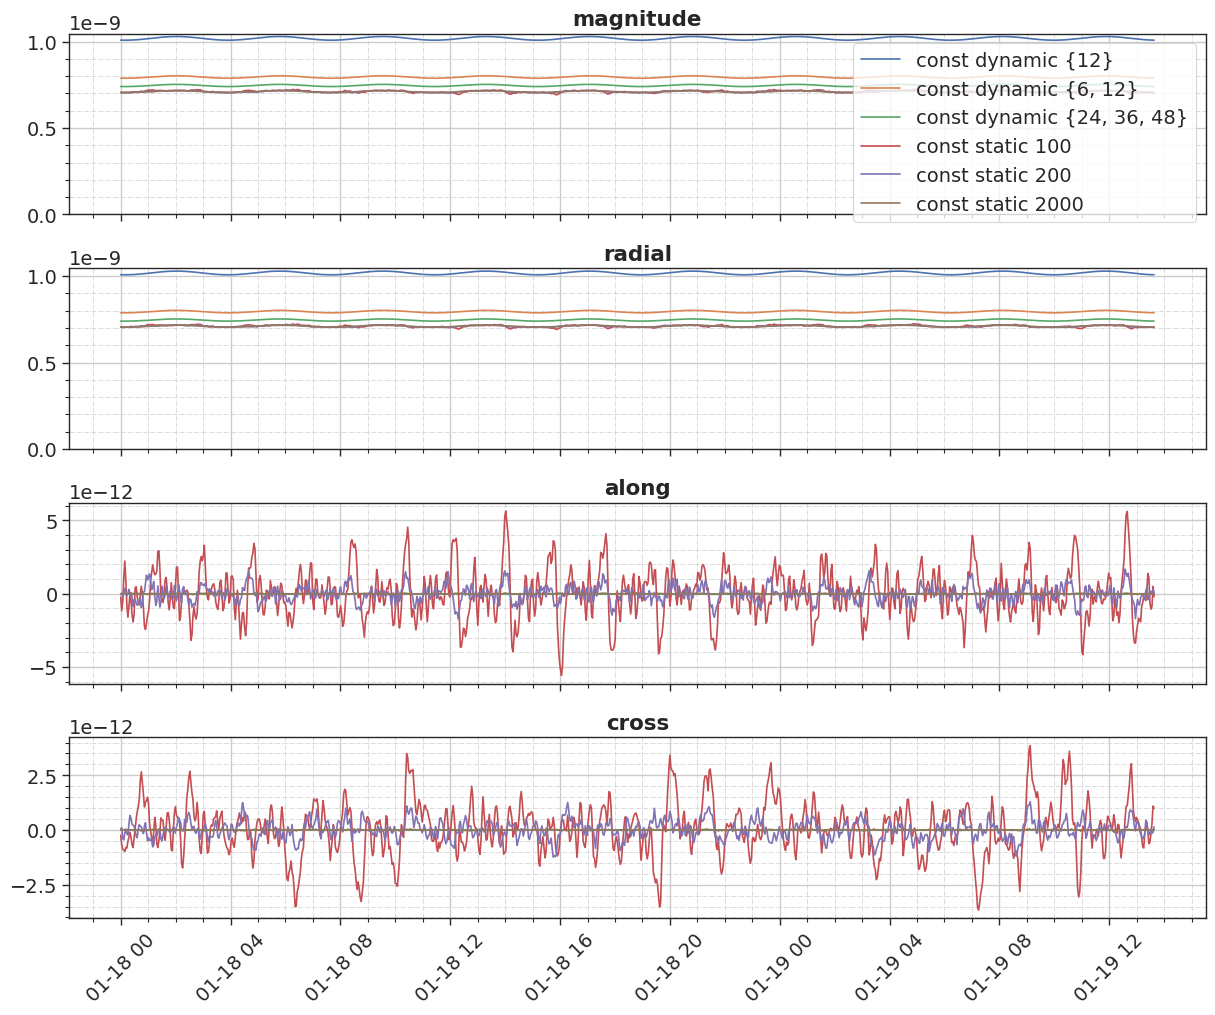

In [16]:
plot_accelerations(
    [df_const_dynamic_single, df_const_dynamic_double, df_const_dynamic_hires, df_const_static_100, df_const_static_200, df_const_static_2000],
    ["const dynamic {12}", "const dynamic {6, 12}", "const dynamic {24, 36, 48}", "const static 100", "const static 200", "const static 2000"]
)

* Dynamic paneling approaches static paneling with more panels

## SH distribution

In [17]:
# static 2000 with SH albedo
df_sh_static_2000 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_static_2000")

In [18]:
# dynamic {24, 36, 48} with SH albedo
df_sh_dynamic_hires = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_dynamic_hires")

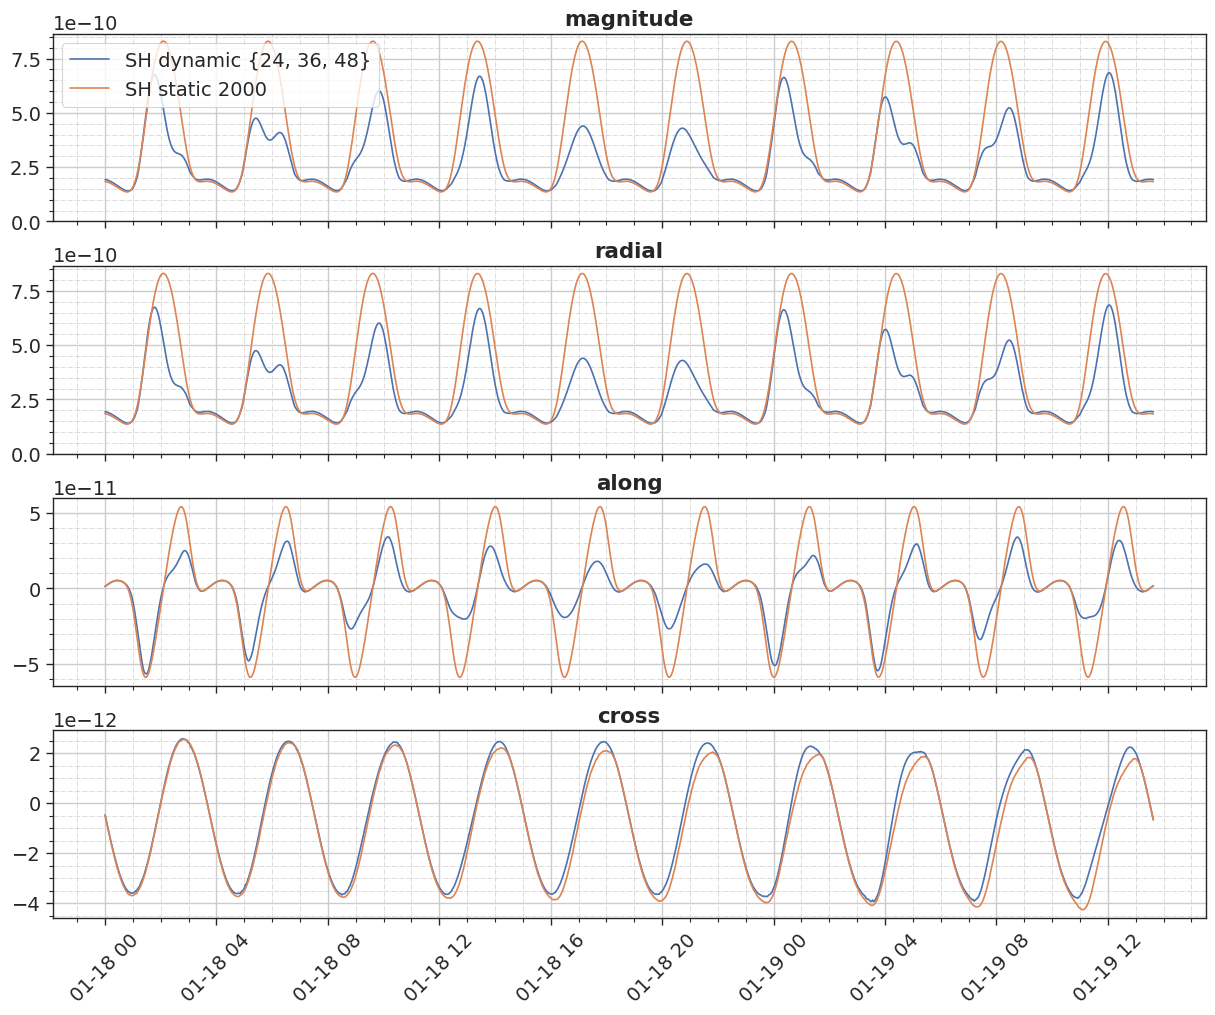

In [19]:
plot_accelerations(
    [df_sh_dynamic_hires, df_sh_static_2000],
    ["SH dynamic {24, 36, 48}", "SH static 2000"]
)

* Static paneling seems to be more stable, but this may just be this particular albedo distribution and orbit

# SH distribution (low orbit)

LAGEOS orbit around Earth but at altitude such that altitude/radius ratio matches LRO

In [20]:
# static 2000 with SH albedo in low orbit
df_sh_static_2000_low = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_static_2000_low")

In [21]:
# dynamic {24, 36, 48} with SH albedo in low orbit
df_sh_dynamic_hires_low = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_dynamic_hires_low")

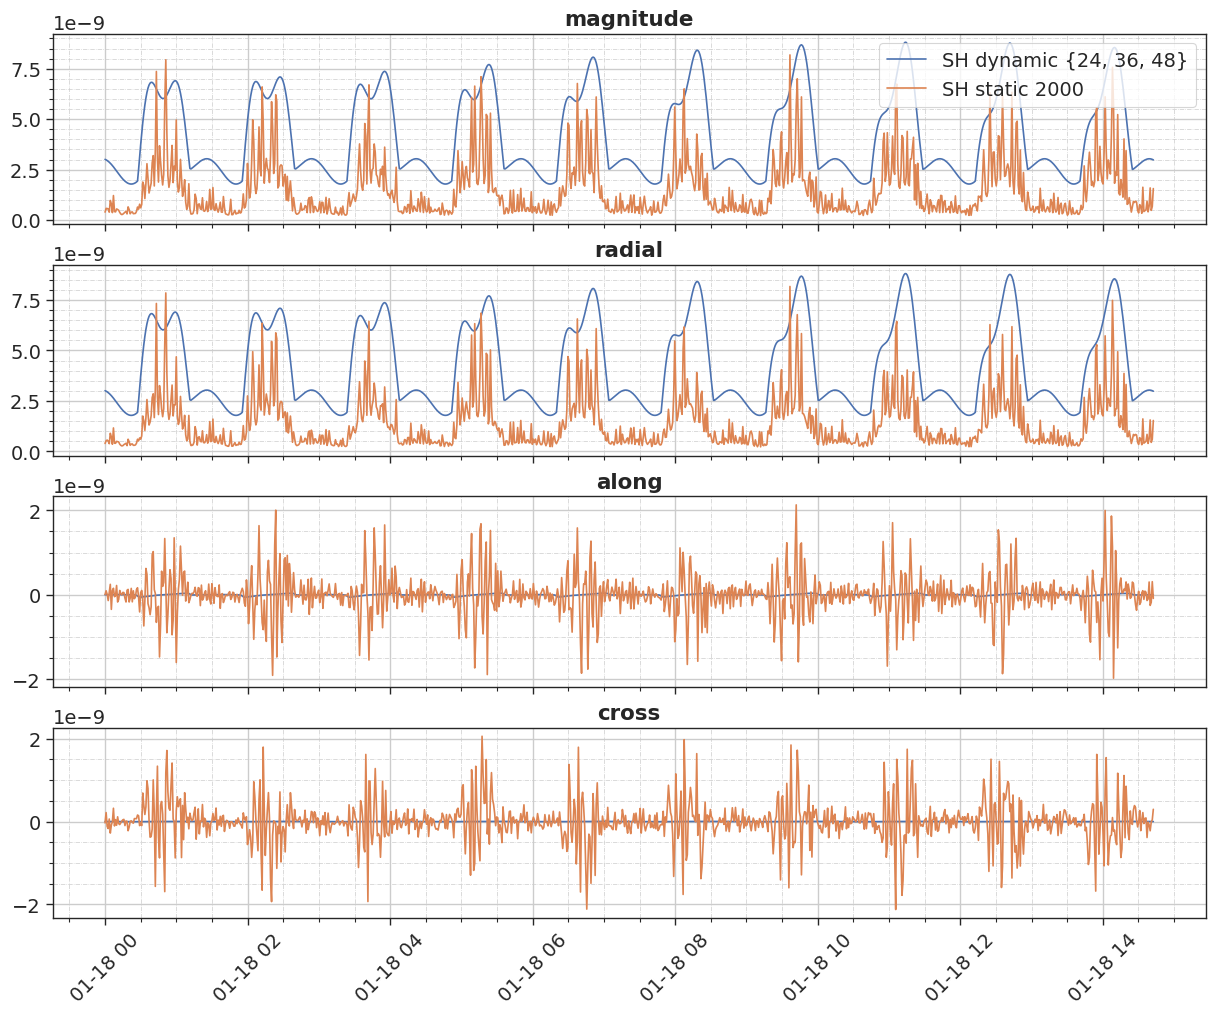

In [22]:
plot_accelerations(
    [df_sh_dynamic_hires_low, df_sh_static_2000_low],
    ["SH dynamic {24, 36, 48}", "SH static 2000"]
)

* Static paneling needs high number for low orbits

# tudat vs Orekit

In [23]:
# {6, 12} with SH albedo
df_knocke_tudat = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat")

In [24]:
# {12} with SH albedo
df_knocke_tudat_single_ring = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_single_ring")

In [25]:
# {24} with SH albedo
df_knocke_tudat_single_ring_24 = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_single_24")

In [26]:
# {24, 24, 24} with SH albedo
df_knocke_tudat_triple_24 = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_triple_24")

In [27]:
# {24, 36, 48} with SH albedo
df_knocke_tudat_hires = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_hires")

In [28]:
# {24, 36, 48} with SH albedo but no thermal
df_knocke_tudat_hires_albedo_only = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_hires_albedo_only")

In [29]:
# {24, 36, 48} with SH thermal but no albedo
df_knocke_tudat_hires_thermal_only = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_hires_thermal_only")

In [30]:
# {24, 24, 24} with SH albedo and summed flux, should be quasi-identical with orekit 15 deg
df_knocke_tudat_triple_24_summed = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_triple_24_summed")

In [31]:
def load_orekit(path):
    with open(f"{path}/data.txt") as f:
        rows = []
        for line in f.readlines():
            elems = line.split()
            date = elems[0]
            acc_radial = float(elems[1])
            acc_along = float(elems[2])
            acc_cross = float(elems[3])
            acc_mag = np.linalg.norm([acc_radial, acc_along, acc_cross])
            rows.append([date, acc_mag, acc_radial, acc_along, acc_cross])

    df = pd.DataFrame(rows, columns=["t", "acc_rp_earth", "acc_rp_earth_radial", "acc_rp_earth_along", "acc_rp_earth_cross"])
    df.index = pd.to_datetime(df["t"])

    return df

In [32]:
# 15 deg res with sin
df_knocke_orekit_15 = load_orekit("../results/vv/knocke_orekit_15")

In [33]:
# 15 deg res with cos
df_knocke_orekit_15_cos = load_orekit("../results/vv/knocke_orekit_15_cos")

In [34]:
(df_knocke_tudat_triple_24["acc_rp_earth"] - df_knocke_tudat_triple_24_summed["acc_rp_earth"]).max()

9.822769774067204e-25

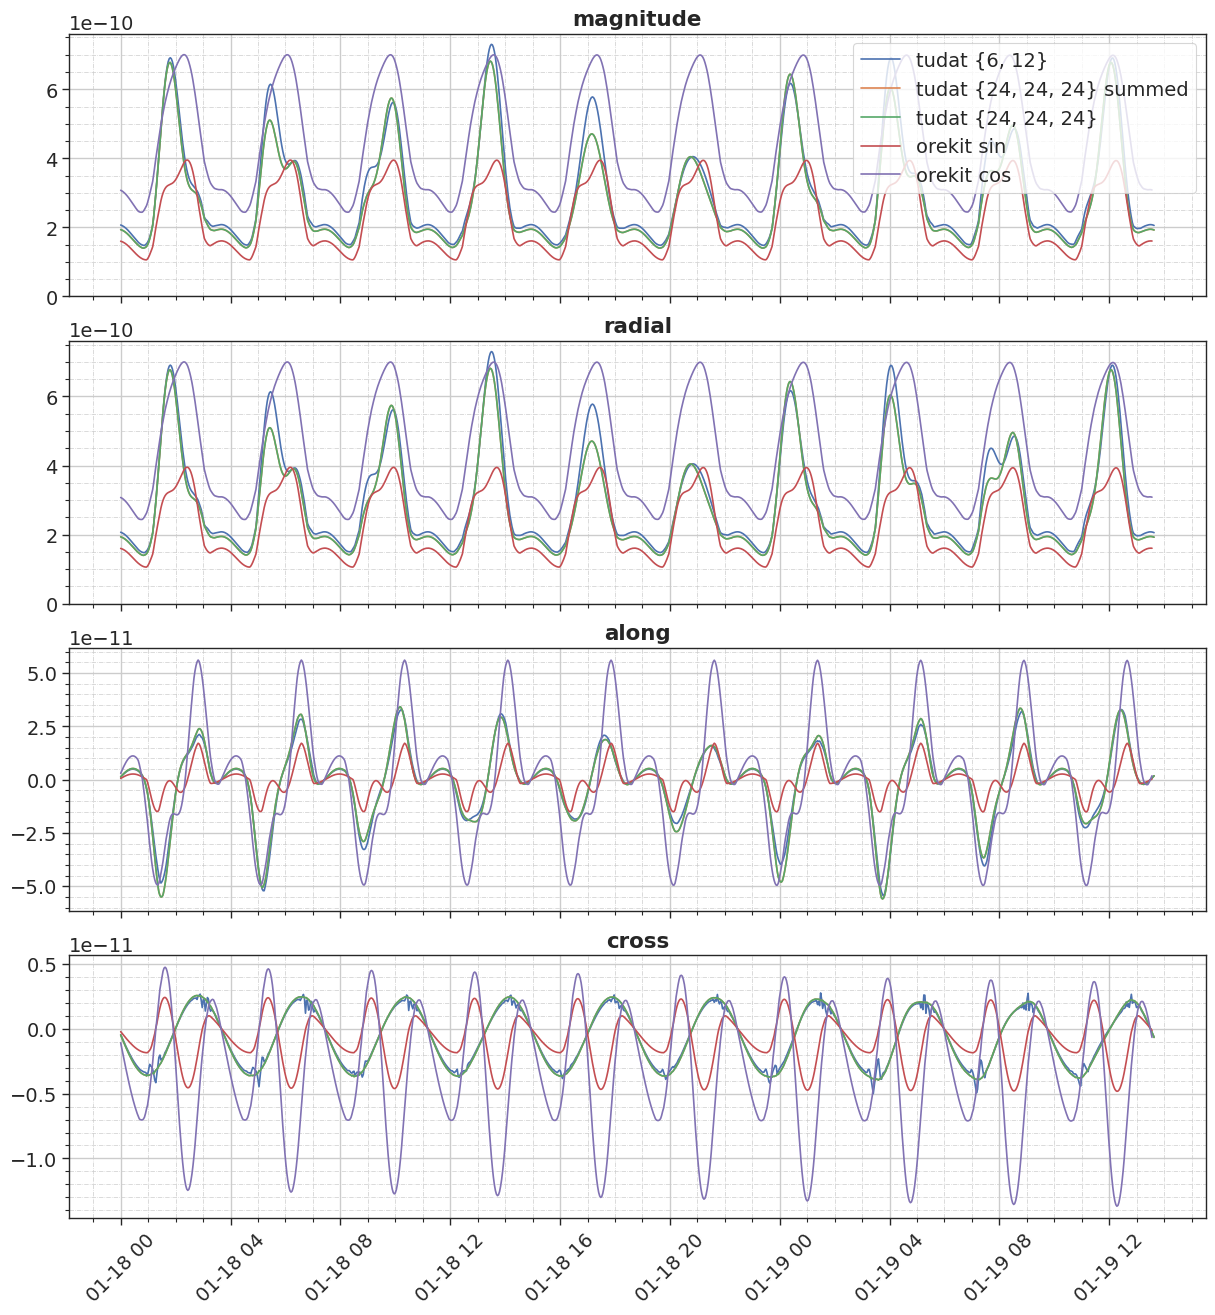

In [35]:
plot_accelerations(
    [df_knocke_tudat, df_knocke_tudat_triple_24_summed, df_knocke_tudat_single_ring, df_knocke_tudat_single_ring_24, df_knocke_tudat_triple_24, df_knocke_tudat_hires, df_knocke_orekit_15, df_knocke_orekit_15_cos],
    ["tudat {6, 12}", "tudat {24, 24, 24} summed", "tudat {12}", "tudat {24}", "tudat {24, 24, 24}", "tudat {24, 36, 48}", "orekit sin", "orekit cos"], skip=["tudat {12}", "tudat {24}", "tudat {24, 36, 48}"], scale_y=1.3)

Orekit uses an angular resolution of 15 deg -> {24} panels with sin bug, {24, 24, 24} with proper cos

* Summing the flux (single incident flux onto s/c instead of one from each panel) does not make any difference -> could reduce computations, but odd that is does not have any effect
* When the cos/sin bug is fixed (https://gitlab.orekit.org/orekit/orekit/-/issues/852) such that the entire spherical cap is filled with panels properly (with sin, the used cap is smaller than the actual visible cap), the magnitude doubles
* Neither of the cos/sin versions agrees well with the tudat results, but the order of magnitude agrees
* Phasing of the cross acceleration is off

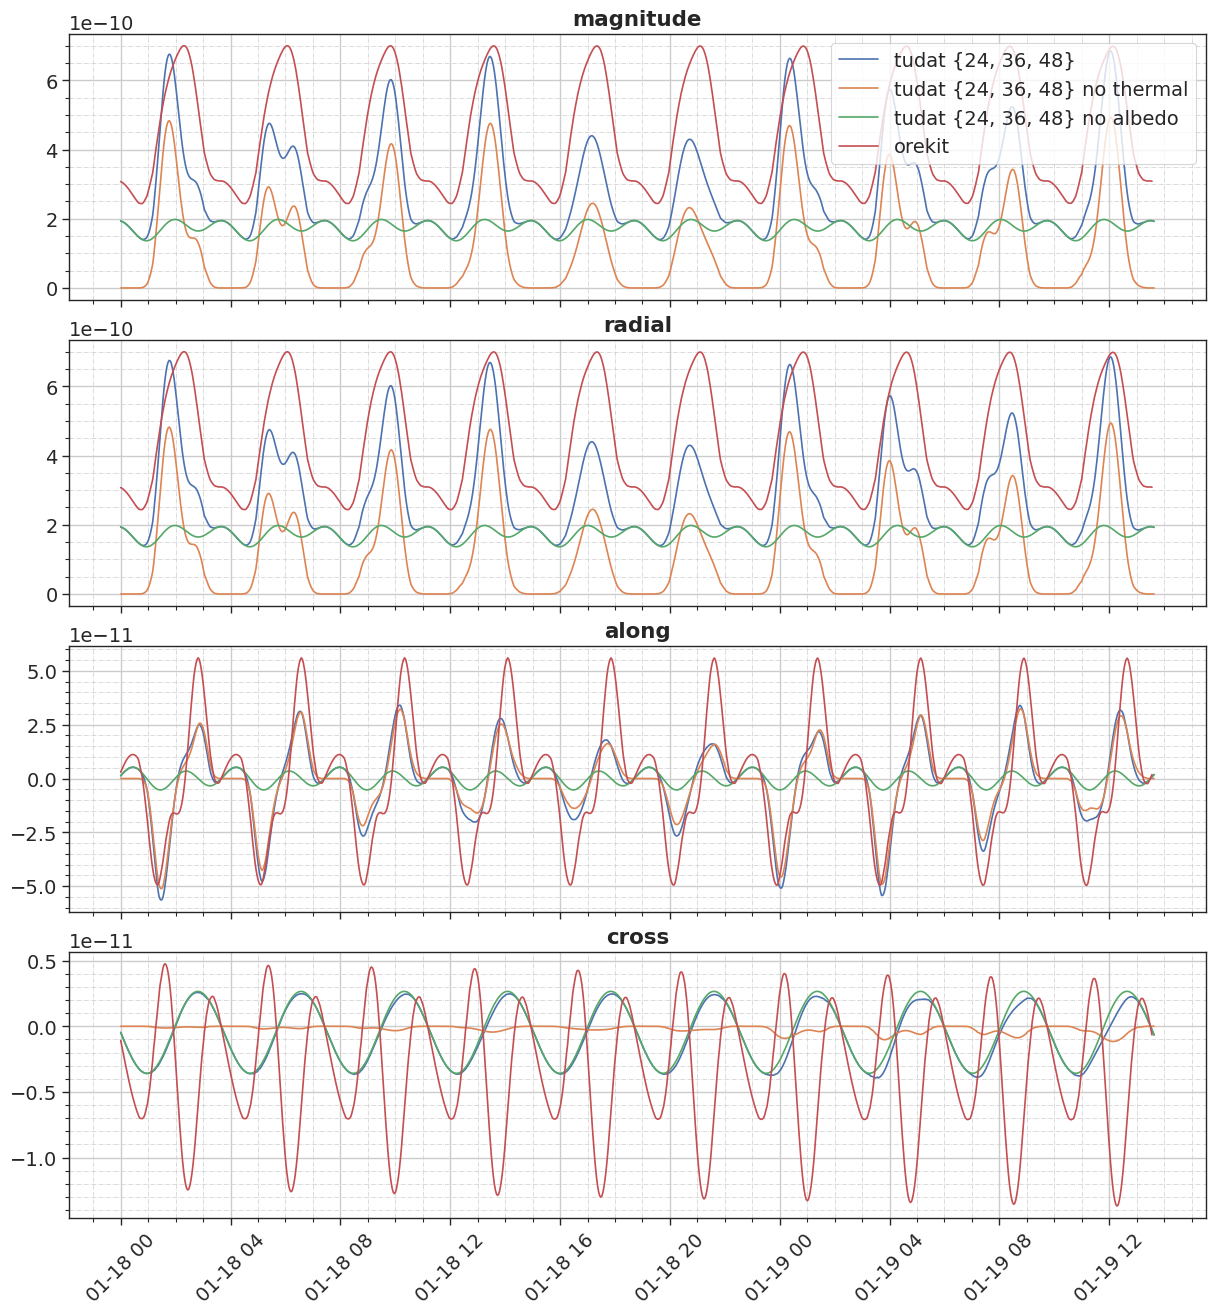

In [36]:
plot_accelerations(
    [df_knocke_tudat_hires, df_knocke_tudat_hires_albedo_only, df_knocke_tudat_hires_thermal_only, df_knocke_orekit_15_cos],
    ["tudat {24, 36, 48}", "tudat {24, 36, 48} no thermal", "tudat {24, 36, 48} no albedo", "orekit"], scale_y=1.3)

Differences between computations in orekit and tudat:
* Orekit uses single summed flux, while we apply fluxes from each panel individually
* Orekit uses an angular resolution instead of a fixed number of panels -> a higher orbit results in more panels, which is not how Knocke did it
* Orekit uses the same angular resolution for zonal and meriodinal flow -> same number of panels per ring

Neither Knocke nor we space panels such that they have equal projected, attenuated area